 **importando el dataset y descomprimiendolo. Ademas de importar las librerias 
necesarias**

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c state-farm-distracted-driver-detection

Saving kaggle.json to kaggle.json
100% 4.00G/4.00G [01:42<00:00, 60.2MB/s]
100% 4.00G/4.00G [01:42<00:00, 41.9MB/s]


In [ ]:
# Descomprimiendo ek dataset
import zipfile

with zipfile.ZipFile('/content/state-farm-distracted-driver-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/conductores')

In [ ]:
from PIL import Image
from skimage import io
from skimage.transform import resize
import albumentations as A
from scipy.io import loadmat
# from pathlib import Path

import os
from glob import glob
import random
import time
import tensorflow
import datetime
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # 3 = INFO, WARNING, and ERROR messages are not printed

from tqdm import tqdm

import numpy as np
import pandas as pd
from IPython.display import FileLink
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
%matplotlib inline
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files       
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16

Dividiendo en datos de prueba y entrenamiento

In [ ]:
dataset = pd.read_csv('/content/conductores/driver_imgs_list.csv')
by_drivers = dataset.groupby('subject')
unique_drivers = by_drivers.groups.keys()

dict_keys(['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081'])


In [ ]:
NUMBER_CLASSES = 10

def get_cv2_image(path, img_rows, img_cols, color_type=3):
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_rows, img_cols)) 
    return img

def load_train(img_rows, img_cols, color_type=3):
    start_time = time.time()
    train_images = [] 
    train_labels = []
    for classed in tqdm(range(NUMBER_CLASSES)):
        print('\nLoading directory c{}'.format(classed))
        files = glob(os.path.join('conductores', 'imgs', 'train', 'c' + str(classed), '*.jpg'))
        for file in files:
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classed)
    print("Data Loaded in {} second".format(time.time() - start_time))
    return train_images, train_labels 

def read_and_normalize_train_data(img_rows, img_cols, color_type):
    X, labels = load_train(img_rows, img_cols, color_type)
    y = np_utils.to_categorical(labels, 10)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    
    return x_train, x_test, y_train, y_test

# Validation
def load_test(size=200000, img_rows=64, img_cols=64, color_type=3):
    path = os.path.join('conductores', 'imgs', 'test', '*.jpg')
    files = sorted(glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_cv2_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)
    
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    
    return test_data, test_ids

In [ ]:
img_rows = 64
img_cols = 64
color_type = 1

In [ ]:
x_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)
print('Train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

  0%|          | 0/10 [00:00<?, ?it/s]


Loading directory c0


 10%|█         | 1/10 [00:08<01:12,  8.04s/it]


Loading directory c1


 20%|██        | 2/10 [00:16<01:07,  8.46s/it]


Loading directory c2


 30%|███       | 3/10 [00:23<00:54,  7.85s/it]


Loading directory c3


 40%|████      | 4/10 [00:31<00:45,  7.57s/it]


Loading directory c4


 50%|█████     | 5/10 [00:38<00:37,  7.57s/it]


Loading directory c5


 60%|██████    | 6/10 [00:49<00:35,  8.81s/it]


Loading directory c6


 70%|███████   | 7/10 [00:55<00:23,  7.81s/it]


Loading directory c7


 80%|████████  | 8/10 [00:58<00:12,  6.38s/it]


Loading directory c8


 90%|█████████ | 9/10 [01:02<00:05,  5.36s/it]


Loading directory c9


100%|██████████| 10/10 [01:05<00:00,  6.55s/it]

Data Loaded in 65.50961494445801 second
Train shape: (17939, 64, 64, 1)
17939 train samples


In [ ]:
nb_test_samples = 200
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)
print('Test shape:', test_files.shape)
print(test_files.shape[0], 'Test samples')

  0%|          | 200/79726 [00:00<02:24, 551.47it/s]

Test shape: (200, 64, 64, 1)
200 Test samples


Estadísticas

In [ ]:
names = [item[17:19] for item in sorted(glob("/content/conductores/imgs/train/*/"))]
test_files_size = len(np.array(glob(os.path.join('/content/conductores/imgs/test', '*.jpg'))))
x_train_size = len(x_train)
categories_size = len(names)
x_test_size = len(x_test)
print('Existen %s imagenes.\n' % (test_files_size + x_train_size + x_test_size))
print('Existen %d imagenes de entrenamiento.' % x_train_size)
print('Existen %d categorías totales de entrenamiento' % categories_size)
print('Existen %d imágenes de validación' % x_test_size)
print('Existen %d imágenes de prueba.'% test_files_size)

There are 102150 total images.

There are 17939 training images.
There are 10 total training categories.
There are 4485 validation images.
There are 79726 test images.


Visualizacion de datos

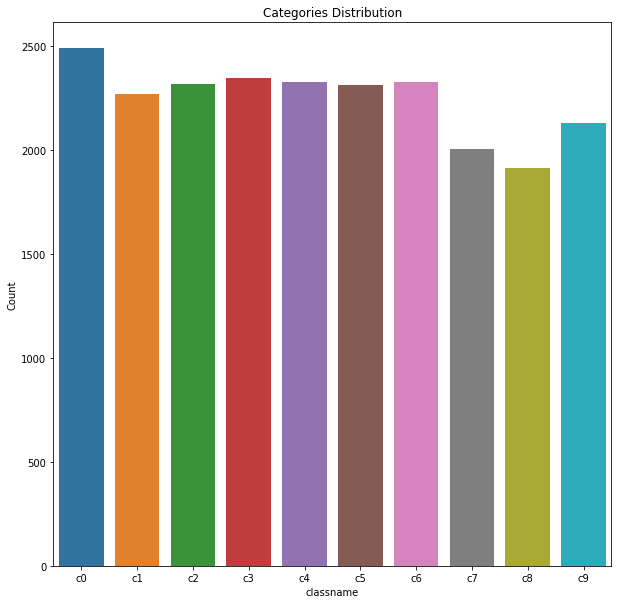

In [ ]:
plt.figure(figsize = (10,10))
sns.countplot(x = 'classname', data = dataset)
plt.ylabel('cantidad')
plt.title('clases')
plt.show()

In [ ]:
drivers_id = pd.DataFrame((dataset['subject'].value_counts()).reset_index())
drivers_id.columns = ['driver_id', 'Counts']

,driver_id,Counts
0,p021,1237
1,p022,1233
2,p024,1226
3,p026,1196
4,p016,1078
5,p066,1034
6,p049,1011
7,p051,920
8,p014,876
9,p015,875


Resumen de imagenes

Echemos un vistazo a las diversas imágenes en el conjunto de datos. Trazaré una imagen para cada una de las 10 clases. Como los nombres de los directorios no son descriptivos, usaré un mapa para definir el título de cada imagen que sea más descriptiva.

In [ ]:
activity_map = {'c0': 'Conducción segura', 
                'c1': 'Mensajes de texto - derecha', 
                'c2': 'Hablar por teléfono - derecha', 
                'c3': 'Mensajes de texto - izquierda', 
                'c4': 'Hablar por teléfono - izquierda', 
                'c5': 'Funcionamiento de la radio', 
                'c6': 'bebiendo', 
                'c7': 'Llegar detrás', 
                'c8': 'Tocandode el cabello', 
                'c9': 'Hablando con el pasajero'}

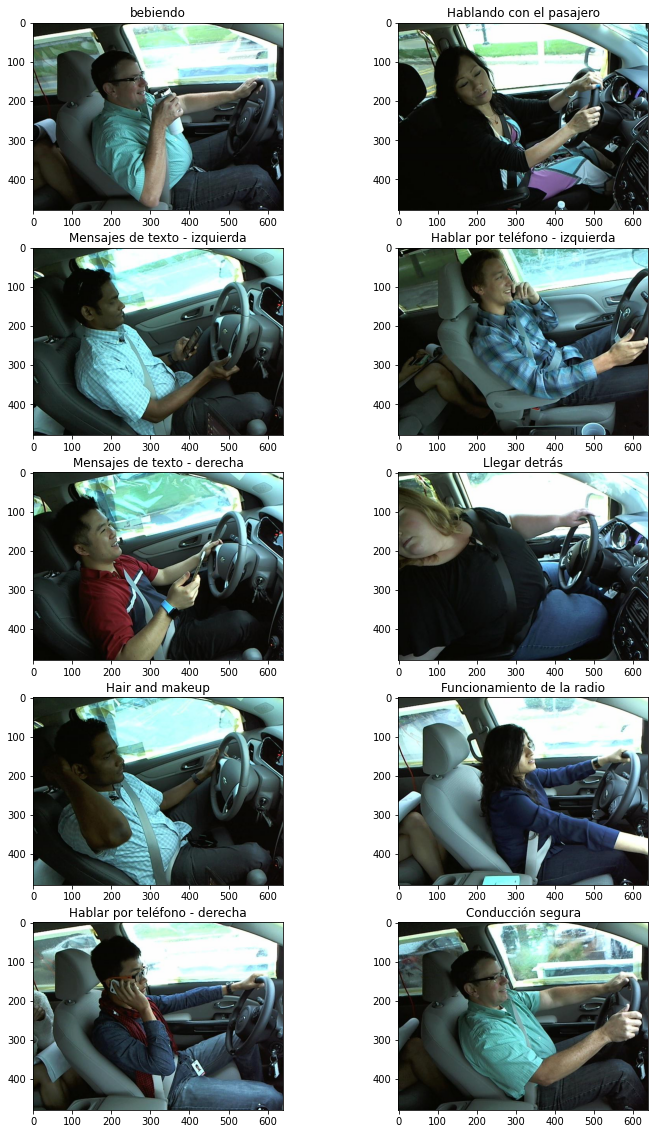

In [ ]:
plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = '/content/conductores/imgs/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])

Construyendo el modelo

In [ ]:
batch_size = 40
nb_epoch = 10

In [ ]:
def plot_train_history(history):
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
def plot_test_class(model, test_files, image_number, color_type=1):
    img_brute = test_files[image_number]
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)

    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)
    print('Y prediction: {}'.format(y_prediction))
    print('Predicted: {}'.format(activity_map.get('c{}'.format(np.argmax(y_prediction)))))
    
    plt.show()

In [ ]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
checkpoint = ModelCheckpoint(filepath='saved_models/weights_best_vgg16.h5', 
                             monitor='val_accuracy', mode='max',
                             verbose=1, save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)
callbacks = [checkpoint, es]


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1.0/255, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True, 
                                   validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale=1.0/ 255, validation_split = 0.2)

Entrena una CNN con Transfer Learning

Para reducir el tiempo de capacitación sin sacrificar la precisión, entrenaré una CNN mediante **transfer learning**.

In [ ]:
def vgg_std16_model(img_rows, img_cols, color_type=3):
    nb_classes = 10
    vgg16_model = VGG16(weights="imagenet", include_top=False)

    # Freeze all layers of the pre-trained model
    for layer in vgg16_model.layers:
        layer.trainable = False
        
    x = vgg16_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)

    predictions = Dense(nb_classes, activation = 'softmax')(x)
    model = Model(inputs = vgg16_model.input, outputs  = predictions)
    
    return model 

In [ ]:
from tensorflow.keras.optimizers import SGD

sgd = SGD(lr = 0.001)

model_vgg16 = vgg_std16_model(img_rows, img_cols)
model_vgg16.summary()
model_vgg16.compile(loss='categorical_crossentropy',optimizer = sgd,metrics=['accuracy'])

Loading network...
58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                           

In [ ]:
print("CArgando red...")
model_vgg16 = vgg_std16_model(img_rows, img_cols)
model_vgg16.summary()
model_vgg16.compile(loss='categorical_crossentropy',
                         optimizer='rmsprop',
                         metrics=['accuracy'])

Loading network...
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None

In [ ]:
training_generator = train_datagen.flow_from_directory('/content/conductores/imgs/train', 
                                                 target_size = (img_rows, img_cols), 
                                                 batch_size = batch_size,
                                                 shuffle=True,
                                                 class_mode='categorical', subset="training")

validation_generator = test_datagen.flow_from_directory('/content/conductores/imgs/train', 
                                                   target_size = (img_rows, img_cols), 
                                                   batch_size = batch_size,
                                                   shuffle=False,
                                                   class_mode='categorical', subset="validation")
nb_train_samples = 17943
nb_validation_samples = 4481

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [ ]:
history_v4 = model_vgg16.fit_generator(training_generator,
                         steps_per_epoch = nb_train_samples // batch_size,
                         epochs = 25, 
                         callbacks=[es, checkpoint],
                         verbose = 1,
                         validation_data = validation_generator,
                         validation_steps = nb_validation_samples // batch_size
                         )

Epoch 1/25
448/448 [==============================] - ETA: 0s - loss: 1.6501 - accuracy: 0.4140
Epoch 1: val_accuracy improved from -inf to 0.53705, saving model to saved_models/weights_best_vgg16.h5
448/448 [==============================] - 144s 294ms/step - loss: 1.6501 - accuracy: 0.4140 - val_loss: 1.2784 - val_accuracy: 0.5371
Epoch 2/25
448/448 [==============================] - ETA: 0s - loss: 1.1746 - accuracy: 0.5921
Epoch 2: val_accuracy improved from 0.53705 to 0.55156, saving model to saved_models/weights_best_vgg16.h5
448/448 [==============================] - 128s 286ms/step - loss: 1.1746 - accuracy: 0.5921 - val_loss: 1.2165 - val_accuracy: 0.5516
Epoch 3/25
448/448 [==============================] - ETA: 0s - loss: 0.9631 - accuracy: 0.6667
Epoch 3: val_accuracy improved from 0.55156 to 0.73594, saving model to saved_models/weights_best_vgg16.h5
448/448 [==============================] - 122s 272ms/step - loss: 0.9631 - accuracy: 0.6667 - val_loss: 0.7703 - val_accura

guardando modelo 

In [ ]:

model_vgg16.save('malaria_model_100epochs.h5')  

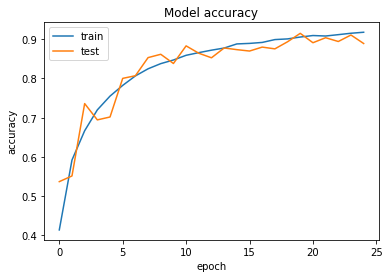

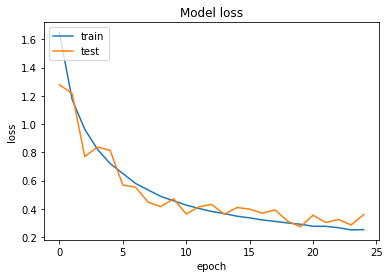

In [ ]:
plot_train_history(history_v4)

In [ ]:
def plot_vgg16_test_class(model, test_files, image_number):
    img_brute = test_files[image_number]

    im = cv2.resize(cv2.cvtColor(img_brute, cv2.COLOR_BGR2RGB), (img_rows,img_cols)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)

    img_display = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_display, cmap='gray')

    y_preds = model.predict(im, batch_size=batch_size, verbose=1)
    print(y_preds)
    y_prediction = np.argmax(y_preds)
    print('Y Prediction: {}'.format(y_prediction))
    print('Predicted as: {}'.format(activity_map.get('c{}'.format(y_prediction))))
    
    plt.show()

1/1 [==============================] - 0s 491ms/step
[[5.0504645e-04 2.7871187e-04 6.4347321e-03 5.3732628e-01 1.3135538e-01
  3.0576533e-03 3.0018577e-01 3.8056250e-04 2.7099292e-04 2.0204913e-02]]
Y Prediction: 3
Predicted as: Mensajes de texto - izquierda


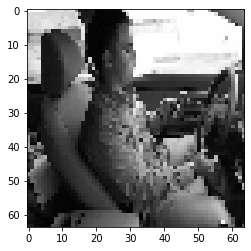

In [ ]:
plot_vgg16_test_class(model_vgg16, test_files, 133) # Texting left

1/1 [==============================] - 0s 18ms/step
[[1.8622229e-02 6.2541671e-06 5.0473050e-06 1.6330820e-02 6.7881268e-01
  7.2619770e-07 2.2142277e-04 2.0062350e-07 1.2389246e-04 2.8587678e-01]]
Y Prediction: 4
Predicted as: Hablar por teléfono - izquierda


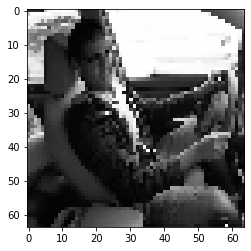

In [ ]:
plot_vgg16_test_class(model_vgg16, test_files, 29) # Texting left

1/1 [==============================] - 0s 20ms/step
[[7.7870517e-04 3.4866621e-09 9.1823771e-10 4.3401788e-10 2.3189186e-04
  4.5720520e-04 1.3844473e-02 1.6426133e-08 9.3370068e-01 5.0986931e-02]]
Y Prediction: 8
Predicted as: Hair and makeup


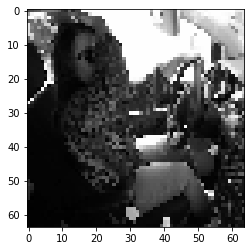

In [ ]:
plot_vgg16_test_class(model_vgg16, test_files, 82) # Hair

In [ ]:
score = model_vgg16.evaluate_generator(validation_generator, nb_validation_samples // batch_size, verbose = 1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

112/112 [==============================] - 20s 180ms/step - loss: 0.3600 - accuracy: 0.8891
Test Score: 0.3600445091724396
Test Accuracy: 0.8890625238418579


--------------------------------------

Otras pruebas

----------------------


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename


In [ ]:
take_photo()

<IPython.core.display.Javascript object>

*******************


In [ ]:
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data
 
# start streaming video from webcam
take_photo()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break
    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      display(js)
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
      }
      ''')

  
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
video_stream()